What we need to do:

read the file line by line
set initial conditions
loop through data
- compute u
- update q using problem 1 math
- update bias b
- update va and vm
extract the rotation angle at each step
plot theta vs time
calculate overall rotation


### To update our orientation, we use this formula

$q_{k+1} = e^{\frac{1}{2}  \Omega(u)\delta t}q_k$

where:

- $k = \frac{t}{\delta t}$ is the integration step

- $e^{\Omega(u)\theta} = \cos(\|u\|\theta)\, I_4 + \sin(\|u\|\theta)\, \frac{\Omega(u)}{\|u\|}$, where we plug in $\theta = \frac{1}{2}\delta t$

- $\Omega(u) = \begin{bmatrix} 0 & -u^\top \\ u & -u_\times \end{bmatrix}$

- $u = \omega_y - \hat{b} + k_p \omega_{mes}$

    - $\omega_y = [\omega_{y,x},\omega_{y,y},\omega_{y,z}]$, inputs from data

    - $\hat{b}_{k+1} = \hat{b}_k - k_I \omega_{mes} \delta t$

    - $\omega_{mes} = k_a v_a \times \hat{v}_a + k_m v_m \times \hat{v}_m$

        - $v_a = \frac{[a_x, a_y, a_z]}{||a||}$ and $v_m = \frac{[m_x, m_y, m_z]}{||m||}$

        - $\hat{v}_{a, k+1} = e^{-u \times \delta t} \hat{v}_{a,k}$, and $\hat{v}_{m,k+1} = e^{-u \times \delta t} \hat{v}_{m,k}$

        - $e^{u \times \theta} = I_3 + sin(||u|| \theta) \frac{u_{\times}}{||u||} + (1 - cos(||u|| \theta )) \frac{u_{\times}^2}{||u||^2}$, where we plug in $\theta = \delta t$ and $u = -u$

### Gains:

$k_p$: Proportional gain used in the orientation update to scale the correction from the measurement error.

$k_I$: Integral gain used for updating the gyroscope bias estimate.

$k_a$: Gain weighting the error between the measured normalized acceleration vector $v_a$ and its estimate $\hat{v}_a$.

$k_m$: Gain weighting the error between the measured normalized magnetic field vector $v_m$ and its estimate $\hat{v}_m$.


### The filter is initialized with the following:

- **Orientation:**

  The initial quaternion is set to the identity:

  $
  q(0) = [1, 0, 0, 0]
  $

- **Gyroscope Bias:**

  The initial bias is assumed to be zero:

  $
  \hat{b}(0) = [0, 0, 0]^T
  $

- **Accelerometer Reference:**

  The inertial gravity vector is defined as:

  $
  a_0 = [0, 0, 1]
  $

  so the normalized vector becomes:

  $
  v_a(0) = \frac{a_0}{\|a_0\|} = [0, 0, 1]
  $

- **Magnetometer Reference:**

  The magnetic north vector is given by:

  $
  m^* = \begin{bmatrix} 0.087117 \\ 0.37923 \\ -0.92119 \end{bmatrix}
  $

  which gives:

  $
  v_m(0) = \frac{m^*}{\|m^*\|}
  $

- **Estimated Vectors:**

  The initial estimated directions are set to the inertial references:

  $
  \hat{v}_a(0) = v_a(0), \quad \hat{v}_m(0) = v_m(0)
  $

- **Time Step:**

  The integration step is constant:

  $
  \delta t = 0.01 \, \text{s}
  $


In [21]:
# TODO pick better values for K

In [22]:
import spatialmath as sm
from spatialmath.base import skew, tr2angvec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm


# Load the CSV file
data = pd.read_csv('question2_input.csv', header=None,
                   names=['t', 'mx', 'my', 'mz', 'gyrox', 'gyroy', 'gyroz', 'ax', 'ay', 'az'])



In [23]:
# Helper Functions
def updateQuaternion(q, u, dt):
    """
    Update the orientation quaternion q using the effective angular velocity u over time dt.
    This implements the closed-form update:
        q_{k+1} = exp((1/2)*Omega(u)*dt) * q_k.
    Here, q is a spatialmath UnitQuaternion and u is a 3-element vector.
    """
    norm_u = np.linalg.norm(u)
    theta = 0.5 * dt
    if norm_u < 1e-8: # divide by 0 prevention
        update_exp = np.eye(4)
    else:
        Omega_u = OMEGA(u)
        update_exp = np.cos(norm_u*theta)*np.eye(4) + (np.sin(norm_u*theta)/norm_u)*Omega_u

    # Multiply update matrix by current quaternion (represented as a 4x1 vector)
    new_q_data = update_exp @ np.array(q.data).reshape(4, 1) # need to reshape so matrix mult works correctly
    new_q_data = new_q_data.flatten() # converts back to 1D array
    new_q_data = new_q_data / np.linalg.norm(new_q_data)  # Normalize, just in case of small floating point errors. should be a unit quaternion anyway
    return sm.UnitQuaternion(new_q_data)

def OMEGA(omega):
    """
    Construct the 4x4 Omega matrix from a 3D angular velocity vector omega.
    """
    omega = np.asarray(omega).flatten() # always ensure it's a 1D array
    if omega.shape != (3,):
        raise ValueError("Input omega must be a 3-element vector.")
    return np.block([
        [0,           -omega.reshape(1,3)],
        [omega.reshape(3,1), -skew(omega)]
    ])

def rodrigues(u, dt):
    """
    Compute the rotation matrix for a rotation of angle theta = ||u||*dt about axis u/||u||,
    using the Rodrigues formula.
    """
    norm_u = np.linalg.norm(u) 
    if norm_u < 1e-8: # prevent division by zero errors
        return np.eye(3)
    theta = norm_u * dt
    u_normalized = u / norm_u
    u_skew = skew(u_normalized)
    R = np.eye(3) + np.sin(theta)*u_skew + (1 - np.cos(theta))*(u_skew @ u_skew)
    return R

def quaternion_to_angle(q):
    """
    Compute the rotation angle (in radians) from the UnitQuaternion q.
    We use the rotation matrix representation and SpatialMath’s tr2angvec.
    """
    ang, axis = tr2angvec(q.R)
    return ang



In [24]:
# Initialize filter variables and inertial references
dt = 0.01 #TODO decide to keep constant time step or not.
num_steps = len(data)

# initial orientation
q = sm.UnitQuaternion()

# Initial gyroscope bias
b = np.zeros(3)

# Inertial acceleration (gravity, normalized) and magnetic field (given, normalized)
a0 = np.array([0, 0, 1])  
m0 = np.array([0.087117, 0.37923, -0.92119])

# Initial Estimate Vectors
v_hat_a = a0.copy() # .copy() copies the content into a new slot in memory
v_hat_m = m0.copy()

# Gains (adjust as needed) TODO adjust these guys to proper values
kp = 1.0     # Proportional gain for orientation correction
kI = 0.1     # Integral gain for bias correction
ka_nominal = 1.0     # Gain for accelerometer error
km_nominal = 1.0     # Gain for magnetometer error

# Expected values
expected_acc = 9.81
expected_mag = np.linalg.norm([4525.28449, 19699.18982, -47850.850686]) / 1000  # Convert nT to µT


# prev_time = data['t'][0] # Time step from the first entry, this will change dynamically in the loop  TODO decide to keep this or not
times = []
rotation_angles = []

#TEMP
m_corrected_array = [] # for graphing
ka_dynamic_list = [] # for graphng
km_dynamic_list = [] # for graphing


# Process the sensor data and update the Mahony filter
for index, row in data.iterrows():
    #update dt to ensure it is consistent with the data TODO decide to keep this or not
    # dt = t - prev_time if index != 0 else t
    # prev_time = t

    # Extract current measurements
    t = row['t']
    m = np.array([row['mx'], row['my'], row['mz']])
    gyro = np.array([row['gyrox'], row['gyroy'], row['gyroz']])
    a = np.array([row['ax'], row['ay'], row['az']])
    
    # Normalize accelerometer measurements
    # If statements prevents divide by zero errors where a = [0, 0, 0] or m = [0, 0, 0]
    if np.linalg.norm(a) != 0:
        v_a = a / np.linalg.norm(a)
    else:
        v_a = a

    # Normalize magnetometer measurements while subtracting gravity component
    #gravity terms
    g_inertial = np.array([0, 0, 1])
    g_body = q.R @ g_inertial
    #projecting m onto g_body, this gives the part of m that is in the gravity direction
    m_vertical = np.dot(m, g_body) * g_body
    m_corrected = m - m_vertical
    if np.linalg.norm(m_corrected) != 0:
        v_m = m_corrected / np.linalg.norm(m_corrected)
    else:
        v_m = m_corrected

    m_corrected_array.append(m_corrected.copy())  #TEMP

    #vvv --------------------------------------- Not Used --------------------------------------- vvv#
    # Calculate dynamic km and ka gains based on gaussian curve
    # compute sensor norms
    a_norm = np.linalg.norm(a)
    m_norm = np.linalg.norm(m_corrected)
    # Compute confidence measures (example using a Gaussian function)
    sigma_a = 0.0677649323574827  # adjusted based on expected variation
    sigma_m = 0.1466190886315767 # adjusted based on expected variation in µT
    # Confidence measures for accelerometer and magnetometer based on guassian distribution
    conf_acc = np.exp(-((a_norm - 9.81)**2) / (2 * sigma_a**2))
    conf_mag = np.exp(-((m_norm - expected_mag)**2) / (2 * sigma_m**2))
    # Scale the nominal gains dynamically
    ka_dynamic = ka_nominal * conf_acc
    km_dynamic = km_nominal * conf_mag
    ka_dynamic_list.append(ka_dynamic)  #TEMP for graphing
    km_dynamic_list.append(km_dynamic)  #TEMP for graphing
    #^^^ --------------------------------------- Not Used --------------------------------------- ^^^#

    
    # Compute the error signals from cross products:
    error_acc = np.cross(v_a, v_hat_a)
    error_mag = np.cross(v_m, v_hat_m)
    omega_mes = ka_nominal * error_acc + km_nominal * error_mag

    # Compute effective angular velocity for the update: 
    u = gyro - b + kp * omega_mes

    # Update the orientation quaternion using our update function
    q = updateQuaternion(q, u, dt)

    # Update the gyroscope bias estimate
    b = b - kI * omega_mes * dt

    # Update the estimated reference vectors using the Rodrigues formula
    R_update = rodrigues(u, dt)

    v_hat_a = R_update @ v_hat_a
    v_hat_a = v_hat_a / np.linalg.norm(v_hat_a)

    v_hat_m = R_update @ v_hat_m
    v_hat_m = v_hat_m / np.linalg.norm(v_hat_m)


    # Store the current time and the rotation angle from the quaternion
    times.append(t)
    rotation_angles.append(quaternion_to_angle(q))


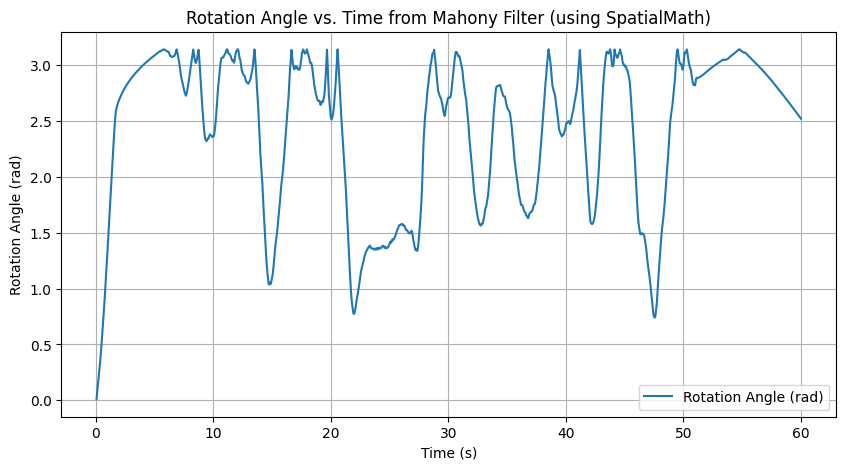

Total rotation over the recorded period: 2.520 radians


In [25]:
# Plot the rotation angle vs. time
plt.figure(figsize=(10, 5))
plt.plot(times, rotation_angles, label='Rotation Angle (rad)')
plt.xlabel('Time (s)')
plt.ylabel('Rotation Angle (rad)')
plt.title('Rotation Angle vs. Time from Mahony Filter (using SpatialMath)')
plt.legend()
plt.grid(True)
plt.show()

# Compute and print the total rotation at the end of the dataset
total_rotation = rotation_angles[-1]
print(f"Total rotation over the recorded period: {total_rotation:.3f} radians")


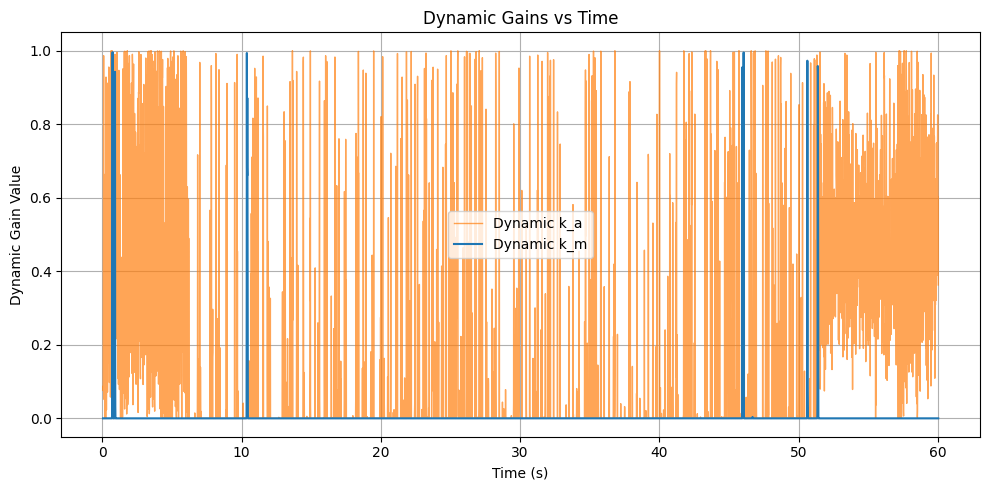

Ka Mean: 0.16848326721297693
Ka Median: 2.4237904625664534e-08

Km Mean: 0.003025753108227913
Km Median: 0.0


In [26]:
# Plot dynamic k_a and k_m versus time
plt.figure(figsize=(10, 5))
plt.plot(times, ka_dynamic_list, label='Dynamic k_a', linewidth=1, color='#ff7f0e', alpha=0.7)
plt.plot(times, km_dynamic_list, label='Dynamic k_m', linewidth=1.5, color='#1f77b4')
plt.xlabel('Time (s)')
plt.ylabel('Dynamic Gain Value')
plt.title('Dynamic Gains vs Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Ka Mean: " + str(np.mean(ka_dynamic_list)))
print("Ka Median: " + str(np.median(ka_dynamic_list)))
print()
print("Km Mean: " + str(np.mean(km_dynamic_list)))
print("Km Median: " + str(np.median(km_dynamic_list)))


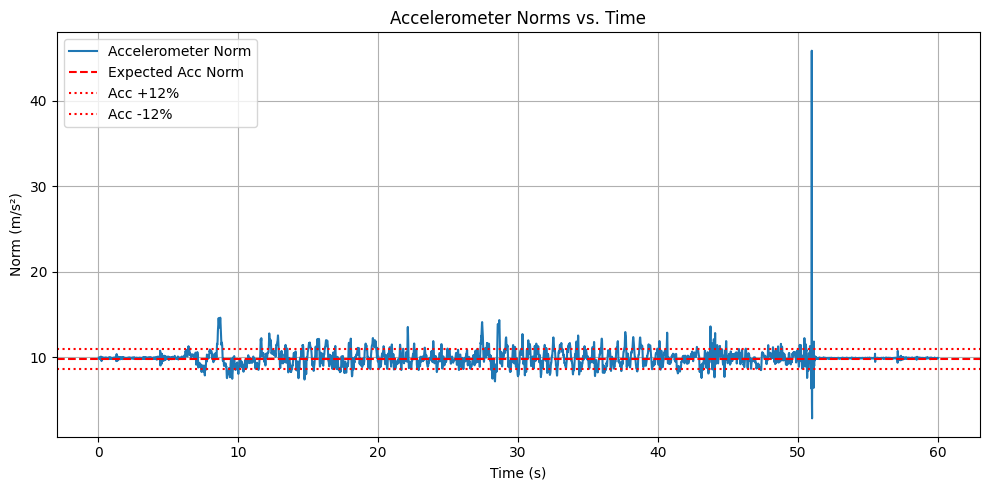

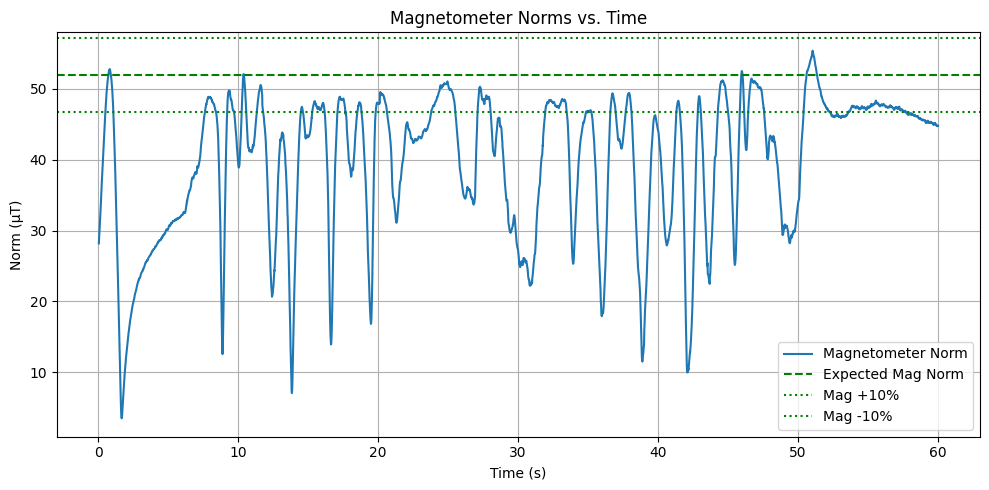

53.02808817500045
sigma_a during rest period: 0.0677649323574827
sigma_m during rest period: 0.8896560350459566

sigma_a during entire period: 1.011706617530009
sigma_m during entire period: 10.01512246895925


In [27]:
# Define percent values for each sensor
percent_value_acc = 0.12   
percent_value_mag = 0.10  

# Expected values
expected_acc = 9.81
expected_mag = np.linalg.norm([4525.28449, 19699.18982, -47850.850686]) / 1000  # Convert nT to µT

# Calculate upper and lower bounds for accelerometer
acc_upper = (1 + percent_value_acc) * expected_acc
acc_lower = (1 - percent_value_acc) * expected_acc

# Calculate upper and lower bounds for magnetometer
mag_upper = (1 + percent_value_mag) * expected_mag
mag_lower = (1 - percent_value_mag) * expected_mag

# Compute the norms of the accelerometer and magnetometer readings over time
times_raw = []
acc_norms = []
mag_norms = []

for index, row in data.iterrows():
    times_raw.append(row['t'])
    a = np.array([row['ax'], row['ay'], row['az']])
    m = np.array(m_corrected_array[index])  # Use the corrected magnetometer data
    acc_norms.append(np.linalg.norm(a))
    mag_norms.append(np.linalg.norm(m))
    # print(m)
    # print(np.linalg.norm(m))

# Create separate plots for accelerometer and magnetometer with default y-limits
# Accelerometer plot
plt.figure(figsize=(10, 5))
plt.plot(times_raw, acc_norms, label='Accelerometer Norm')
plt.axhline(y=expected_acc, color='red', linestyle='--', label='Expected Acc Norm')
plt.axhline(y=acc_upper, color='red', linestyle=':', label=f'Acc +{int(percent_value_acc*100)}%')
plt.axhline(y=acc_lower, color='red', linestyle=':', label=f'Acc -{int(percent_value_acc*100)}%')
plt.xlabel('Time (s)')
plt.ylabel('Norm (m/s²)')
plt.title('Accelerometer Norms vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Magnetometer plot
plt.figure(figsize=(10, 5))
plt.plot(times_raw, mag_norms, label='Magnetometer Norm')
plt.axhline(y=expected_mag, color='green', linestyle='--', label='Expected Mag Norm')
plt.axhline(y=mag_upper, color='green', linestyle=':', label=f'Mag +{int(percent_value_mag*100)}%')
plt.axhline(y=mag_lower, color='green', linestyle=':', label=f'Mag -{int(percent_value_mag*100)}%')
plt.xlabel('Time (s)')
plt.ylabel('Norm (µT)')
plt.title('Magnetometer Norms vs. Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(times_raw[len(times_raw)-650])

sigma_a = np.std(acc_norms[len(times_raw)-650:-1])  # standard deviation of accelerometer norms
sigma_m = np.std(mag_norms[len(times_raw)-650:-1])  # standard deviation of magnetometer norms

print("sigma_a during rest period:", sigma_a)
print("sigma_m during rest period:", sigma_m)

print()

sigma_a = np.std(acc_norms)  # standard deviation of accelerometer norms
sigma_m = np.std(mag_norms)  # standard deviation of magnetometer norms

print("sigma_a during entire period:", sigma_a)
print("sigma_m during entire period:", sigma_m)

